In [1]:
# Import necessary libraries for numerical operations, plotting, random choices, and data manipulation.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import matplotlib.patches as mpatches
import pandas as pd

# Set random seeds for NumPy and Python's `random` module.
# This ensures that the simulation results are reproducible each time the code is run with the same seed.
# If reproducibility is not required, these lines can be commented out.
np.random.seed(32)
random.seed(32)

# Global Simulation Parameters

# These parameters define the fundamental structure and scale of the simulated genetic system and populations.
# They are set globally and are used across various functions and classes in the simulation.

# chromosome_length: The total number of genetic loci (marker positions) present on a single haploid chromatid.
# This value determines the resolution of the genetic data captured for each chromosome.
chromosome_length = 100

# NUM_CHROMOSOMES_P0_F1: The number of diploid chromosome pairs that individuals in the P0 and F1 generations possess.
# For simplicity, P0 and F1 individuals are modelled with a single chromosome pair.
NUM_CHROMOSOMES_P0_F1 = 1

# NUM_CHROMOSOMES_F2_ONWARDS: The target number of diploid chromosome pairs for individuals from the F2 generation onwards.
# This allows for modelling a more complex genome with multiple independently assorting chromosomes in later generations.
NUM_CHROMOSOMES_F2_ONWARDS = 10

# Population Sizes for Different Generations
# These global constants define the target number of individuals to be simulated for each generation.

NUM_F1_INDIVIDUALS = 100    # Number of individuals in the F1 generation.
NUM_F2_INDIVIDUALS = 5000   # Number of individuals in the F2 generation.
NUM_F3_INDIVIDUALS = 5000   # Number of individuals in the F3 generation.
NUM_F4_INDIVIDUALS = 5000   # Number of individuals in the F4 generation.

# Number of individuals for Backcross generations.
# BC1_A: Backcross of F1 to P0_A (MM parent)
NUM_BC1_A_INDIVIDUALS = 5000
# BC1_B: Backcross of F1 to P0_B (YY parent)
NUM_BC1_B_INDIVIDUALS = 5000
# BC2_A: Backcross of F2 to P0_A (MM parent)
NUM_BC2_A_INDIVIDUALS = 5000

# Define allele types and their corresponding colours for visualisation.
MAGENTA = 'M' # Represents the allele from parental line A (MM).
YELLOW = 'Y'  # Represents the allele from parental line B (YY).

# Global colour map: associates allele symbols with specific colours for plotting.
col_map = {MAGENTA: 'magenta', YELLOW: 'yellow'}

# Global list to store all detailed genetic data records (locus-level genotypes).
# Each dictionary in this list will represent the genotype at a single locus for a given individual.
genetic_data_records = []

# Global counter for assigning unique identification numbers to each individual created in the simulation.
# Starts at 1 to ensure individual IDs are 1-indexed for clarity and common biological practice.
individual_id_counter = 1

In [2]:
# Class Definitions (Chromosome, DiploidChromosomePair, Individual)

# This cell defines the fundamental biological entities that form the basis of the genetic simulation:
# a single DNA strand (Chromosome), a pair of homologous chromosomes (DiploidChromosomePair),
# and an entire organism (Individual). The 'Individual' class is extended with methods
# to calculate key genetic metrics such as Hybrid Index and Heterozygosity.

class Chromosome:
    """
    Represents a single haploid chromatid (a single strand of DNA).
    It is a linear sequence of alleles at defined loci.
    In a diploid organism, two homologous chromatids form a chromosome pair.
    """
    def __init__(self, alleles):
        # 'alleles' is a list of characters (e.g., 'M', 'Y'), where each character
        # corresponds to the allele present at a specific locus on this chromatid.
        self.alleles = alleles

    def __repr__(self):
        # Provides a developer-friendly string representation of a Chromosome object.
        # It displays a snippet of the alleles to give an idea of its content without printing the entire sequence.
        snippet = ''.join(self.alleles[:10]) if self.alleles else ''
        return f"Chr({snippet}...)"

class DiploidChromosomePair:
    """
    Represents a homologous pair of chromosomes within a diploid organism.
    One chromatid in the pair is typically inherited from one parent (e.g., paternal origin),
    and the other from the other parent (e.g., maternal origin).
    """
    def __init__(self, chromatid1, chromatid2):
        # 'chromatid1' and 'chromatid2' are instances of the Chromosome class.
        # These represent the two homologous chromatids that constitute this diploid pair.
        self.chromatid1 = chromatid1
        self.chromatid2 = chromatid2

    def __repr__(self):
        # Provides a string representation for a DiploidChromosomePair, showing both constituent chromatids.
        return f"Pair(\n  {self.chromatid1}\n  {self.chromatid2}\n)"

class Individual:
    """
    Represents a single organism in the simulation. An individual is defined by its
    unique ID, total number of chromosome pairs, and the length of those chromosomes.
    This class includes methods to calculate the Hybrid Index and Heterozygosity
    across the entire genome of the individual.
    """
    def __init__(self, num_chromosomes, num_loci_per_chromosome):
        global individual_id_counter # Access the global counter to assign unique IDs.
        self.id = individual_id_counter # Assign a unique integer ID to this individual.
        individual_id_counter += 1 # Increment the counter for the next individual to be created.

        # 'num_chromosomes': The total count of diploid chromosome pairs this individual possesses.
        self.num_chromosomes = num_chromosomes
        # 'num_loci_per_chromosome': The number of loci found on each individual chromatid.
        self.num_loci_per_chromosome = num_loci_per_chromosome
        # 'diploid_chromosome_pairs': A list that will hold all the DiploidChromosomePair objects
        #                             that make up this individual's entire genome.
        self.diploid_chromosome_pairs = []

    def __repr__(self):
        # A concise string representation for an Individual, indicating its ID and the number of chromosome pairs.
        return f"Individual (ID: {self.id}) with {len(self.diploid_chromosome_pairs)} diploid chromosome pairs."

    def get_all_numeric_genotypes(self):
        """
        Gathers all genotype data for the individual across its entire genome (all chromosome pairs, all loci).
        It converts the allele pairs (e.g., 'M', 'Y') into a numeric representation for calculation:
        - YY (homozygous Yellow) = 0 (zero 'M' alleles)
        - MY (heterozygous)      = 1 (one 'M' allele)
        - MM (homozygous Magenta)= 2 (two 'M' alleles)

        Returns:
            list: A single, flattened list of integers (0, 1, or 2) representing the genotype at each locus
                  across *all* diploid chromosome pairs of this individual. This is the raw data used for metrics.
        """
        all_numeric_genotypes = []
        # Iterate through each diploid chromosome pair that belongs to this individual.
        for diploid_pair in self.diploid_chromosome_pairs:
            # Get the allele sequences from both homologous chromatids in the current pair.
            alleles_chromatid1 = diploid_pair.chromatid1.alleles
            alleles_chromatid2 = diploid_pair.chromatid2.alleles

            # Iterate through each locus (position) along the length of these chromatids.
            for i in range(self.num_loci_per_chromosome):
                allele_a = alleles_chromatid1[i]
                allele_b = alleles_chromatid2[i]
                # Sort the alleles to ensure consistent ordering (e.g., 'MY' instead of 'YM')
                # before assigning a numeric genotype.
                pair = sorted([allele_a, allele_b])

                # Assign numeric genotype based on the sorted allele pair composition.
                if pair == [MAGENTA, MAGENTA]: # Homozygous for Magenta alleles.
                    all_numeric_genotypes.append(2)
                elif pair == [YELLOW, YELLOW]: # Homozygous for Yellow alleles.
                    all_numeric_genotypes.append(0)
                else: # Must be heterozygous (one Magenta, one Yellow allele).
                    all_numeric_genotypes.append(1)
        return all_numeric_genotypes

    def calculate_hybrid_index(self):
        """
        Calculates the aggregate Hybrid Index (HI) for this individual across its entire genome.
        The HI quantifies the proportion of alleles originating from one parental lineage (specifically Magenta 'M')
        out of all alleles across all loci. It ranges from 0 (all Yellow alleles) to 1 (all Magenta alleles).

        Returns:
            float: The calculated Hybrid Index for the individual, aggregated across all chromosomes.
        """
        # First, retrieve all numeric genotypes for the individual's entire genome.
        all_numeric_genotypes = self.get_all_numeric_genotypes()
        
        # Calculate the total number of alleles across the entire genome.
        # Since each locus has two alleles (one from each chromatid in a diploid pair),
        # the total possible alleles is twice the number of loci.
        total_possible_alleles = len(all_numeric_genotypes) * 2 
        
        # Prevent division by zero in the rare case of an individual having no loci (e.g., an empty Individual object).
        if total_possible_alleles == 0:
            return 0.0

        # The sum of numeric genotypes (0 for YY, 1 for MY, 2 for MM) directly corresponds
        # to the total count of 'M' (Magenta) alleles present in the individual's genome.
        sum_of_m_alleles = sum(all_numeric_genotypes)
        
        # The Hybrid Index is the proportion of Magenta alleles out of the total possible alleles.
        hybrid_index = sum_of_m_alleles / total_possible_alleles
        return hybrid_index

    def calculate_heterozygosity(self):
        """
        Calculates the aggregate Heterozygosity (He) for this individual across its entire genome.
        Heterozygosity represents the proportion of heterozygous loci (MY genotypes)
        out of all loci in the individual's genome. It ranges from 0 (all loci homozygous)
        to 1 (all loci heterozygous).

        Returns:
            float: The calculated Heterozygosity for the individual, aggregated across all chromosomes.
        """
        # Retrieve all numeric genotypes for the individual's full genome.
        all_numeric_genotypes = self.get_all_numeric_genotypes()
        
        # Count how many of these loci are heterozygous (where the numeric genotype is 1).
        num_heterozygous_loci = all_numeric_genotypes.count(1) 
        
        # The total number of loci across the entire genome is simply the total count
        # of numeric genotypes that were collected.
        total_num_loci_across_all_chroms = len(all_numeric_genotypes) 
        
        # Prevent division by zero if the individual has no loci.
        if total_num_loci_across_all_chroms == 0:
            return 0.0

        # Heterozygosity is the proportion of heterozygous loci out of all loci.
        heterozygosity = num_heterozygous_loci / total_num_loci_across_all_chroms
        return heterozygosity

# Helper function to record an individual's detailed genomic data into the global list.
def _record_individual_genome_for_detailed_dataframe(individual, generation_stage_label):
    """
    Records the detailed genotype information for an individual at each locus
    into the global 'genetic_data_records' list. This list will later be converted
    into a pandas DataFrame for comprehensive data analysis.

    Args:
        individual (Individual): The individual whose genome data is to be recorded.
        generation_stage_label (str): A string label indicating the generation stage of the individual
                                      (e.g., "P0_A", "F1", "F2", "BC1_A").
    """
    # Iterate through each diploid chromosome pair that the individual possesses.
    # 'chr_idx' serves as a 0-indexed counter for the chromosome pair.
    for chr_idx, diploid_pair in enumerate(individual.diploid_chromosome_pairs):
        # Iterate through each locus position along the length of the chromosomes.
        for locus_idx in range(individual.num_loci_per_chromosome):
            # Extract the alleles from both chromatids at the current locus.
            allele_a = diploid_pair.chromatid1.alleles[locus_idx]
            allele_b = diploid_pair.chromatid2.alleles[locus_idx]
            
            # Sort the alleles (e.g., ensures 'M|Y' instead of 'Y|M') for consistent genotype representation.
            sorted_alleles = sorted([allele_a, allele_b])
            # Form a genotype string representing the alleles at this locus.
            genotype_str = f"{sorted_alleles[0]}|{sorted_alleles[1]}"
            
            # Append a dictionary representing this locus's data to the global records list.
            # 'diploid_chromosome_id' is 1-indexed for better readability (e.g., Chr 1, Chr 2).
            genetic_data_records.append({
                'generation': generation_stage_label,
                'individual_id': individual.id,
                'diploid_chromosome_id': chr_idx + 1,
                'locus_position': locus_idx,
                'genotype': genotype_str # The combined genotype at this specific locus (e.g., 'M|Y').
            })

In [3]:
# Recombination Setup

# This cell defines the probabilities that govern how genetic recombination (crossovers) occurs
# during gamete formation. These probabilities dictate how parental alleles are shuffled
# onto new chromatids.

# use_uniform_recomb: A boolean flag to switch between two recombination models.
# - True: Uses a constant, uniform recombination probability across the entire chromosome.
# - False: Uses a custom, locus-specific recombination probability profile.
use_uniform_recomb = True # Set to True for this simulation to use uniform recombination.

if use_uniform_recomb:
    # Uniform Recombination Model:
    # Each interval between adjacent loci (marker sites) has an equal chance of a crossover occurring.
    # A probability of 0.5 effectively means independent assortment between adjacent loci if no interference.
    # There are (chromosome_length - 1) intervals on a chromosome.
    recomb_probs_for_crosses = [0.5] * (chromosome_length - 1)
else:
    # Custom Recombination Model:
    # This setup allows for varying recombination rates along the chromosome, simulating "hotspots" or "coldspots".
    recomb_probs_for_crosses = [0.0] * (chromosome_length - 1) # Initialize all intervals with 0.0 recombination probability.
    for i in range(chromosome_length - 1):
        # Define a specific region (from locus 45 to 54, inclusive) as a "hotspot" with
        # a higher recombination probability (0.1).
        if 45 <= i < 55:
            recomb_probs_for_crosses[i] = 0.1

# recomb_event_probs_for_crosses: Defines the probabilities of a specific number of crossover events occurring
# on a single chromatid during meiosis.
# This list is a probability distribution: P(0 crossovers), P(1 crossover), P(2 crossovers).
# [0, 1, 0] means that exactly one crossover event will always occur if recombination is enabled and possible.
recomb_event_probs_for_crosses = [0, 1, 0]

In [4]:
# Gamete Formation and Offspring Generation Helper Functions

# This cell contains the sophisticated functions that simulate how parents produce gametes
# (haploid sets of chromosomes) and how these gametes combine to form offspring.
# This is where recombination, the shuffling of parental alleles, takes place.

def form_gamete_from_diploid_pair(diploid_chromosome_pair, chromosome_length, recomb_event_probabilities, recomb_probabilities):
    """
    Simulates the process of meiosis for a single diploid chromosome pair to produce one haploid chromatid.
    This function accounts for crossover events (recombination) between the two homologous chromatids
    within the pair, generating a recombinant chromatid for the gamete.

    Args:
        diploid_chromosome_pair (DiploidChromosomePair): The parental chromosome pair from which the gamete is formed.
        chromosome_length (int): The total number of loci on the chromosome.
        recomb_event_probabilities (list): A list of probabilities for 0, 1, or 2 crossover events.
                                   (e.g., [P(0_crossovers), P(1_crossover), P(2_crossovers)]).
        recomb_probabilities (list): A list of probabilities for a crossover occurring at each specific
                             interval between adjacent loci. (Length = chromosome_length - 1).

    Returns:
        Chromosome: A newly generated haploid Chromosome object, which is a recombinant chromatid.
    """
    # Extract the allele sequences from the two homologous chromatids in the diploid pair.
    parent_alleles_strand1 = diploid_chromosome_pair.chromatid1.alleles
    parent_alleles_strand2 = diploid_chromosome_pair.chromatid2.alleles

    # Handle very short chromosomes (length <= 1) as recombination is not meaningful.
    # In such cases, simply choose one of the parental strands to pass on directly.
    if chromosome_length <= 1:
        chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
        return Chromosome(list(chosen_strand))

    # Determine the number of crossover events that will occur on this chromatid,
    # based on the provided probabilities (recomb_event_probabilities).
    num_recombs = random.choices([0, 1, 2], weights=recomb_event_probabilities, k=1)[0]
    
    # Ensure that the number of recombination events doesn't exceed the physically
    # possible number of intervals between loci (chromosome_length - 1).
    max_crossovers_possible = chromosome_length - 1
    num_recombs = min(num_recombs, max_crossovers_possible) 

    # If no recombination events are determined (num_recombs is 0), or if the
    # recombination probabilities across all intervals sum to zero (meaning no
    # crossover can happen), then simply return a non-recombinant copy of one
    # of the parental strands.
    if num_recombs == 0 or sum(recomb_probabilities) == 0:
        chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
        return Chromosome(list(chosen_strand))

    # If recombination is to occur:
    # Select the specific locations (indices of intervals) where crossovers will happen.
    # `random.choices` is used with `weights` to allow for non-uniform recombination rates (hotspots/coldspots).
    crossover_point_indices = random.choices(range(max_crossovers_possible), weights=recomb_probabilities, k=num_recombs)
    # Convert to a sorted set to get unique crossover points and ensure they are processed in order along the chromosome.
    crossover_points = sorted(list(set(crossover_point_indices))) 

    # Initialize the gamete chromatid's alleles.
    gamete_alleles = [None] * chromosome_length
    # Randomly choose which of the two parental strands (chromatid1 or chromatid2) to start copying from.
    current_source_alleles = list(parent_alleles_strand1) if random.random() < 0.5 else list(parent_alleles_strand2)
    # The other strand is the alternative source, which will be swapped to after a crossover.
    other_source_alleles = list(parent_alleles_strand2) if current_source_alleles == list(parent_alleles_strand1) else list(parent_alleles_strand1)

    current_segment_start_idx = 0 # Marks the beginning of the current segment being copied.

    # Iterate through each determined crossover point.
    for crossover_point_idx in crossover_points:
        # A crossover at `crossover_point_idx` means the genetic material switches *after* that locus.
        # So, the segment goes from `current_segment_start_idx` up to `crossover_point_idx + 1` (exclusive).
        segment_end = crossover_point_idx + 1 
        
        # Copy the alleles for the current segment from the `current_source_alleles` strand.
        for i in range(current_segment_start_idx, segment_end):
            gamete_alleles[i] = current_source_alleles[i]

        # After copying a segment, a crossover occurs, so swap the source strands for the next segment.
        current_source_alleles, other_source_alleles = other_source_alleles, current_source_alleles
        # Update the starting index for the next segment to be copied.
        current_segment_start_idx = segment_end 

    # After all crossovers are processed, copy the remaining alleles from the final source strand
    # to complete the construction of the gamete chromatid.
    for i in range(current_segment_start_idx, chromosome_length):
        gamete_alleles[i] = current_source_alleles[i]

    return Chromosome(gamete_alleles)

def produce_haploid_set_of_chromosomes_for_gamete(parent_individual, chromosome_length, recomb_event_probabilities, recomb_probabilities, target_num_chromosomes_in_gamete_set=None):
    """
    Generates a complete set of haploid chromatids that would make up a gamete (e.g., sperm or egg).
    For each diploid chromosome pair in the parent, one recombinant chromatid is produced.
    
    A crucial feature here is handling cases where the parent has *fewer* chromosome pairs than the
    target number for the offspring's gamete set (e.g., P0 parents with 1 chromosome contributing to F2 with 10).
    In such scenarios, gametes from the parent's *first* chromosome pair are replicated to meet the target count,
    simulating independent assortment for new chromosomes if the parent only has one "model" chromosome.

    Args:
        parent_individual (Individual): The parent organism from which the gamete set is being generated.
        chromosome_length (int): The number of loci on each chromosome.
        recomb_event_probabilities (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probabilities (list): Locus-specific recombination probabilities.
        target_num_chromosomes_in_gamete_set (int, optional): The desired number of chromatids in the
                                                              returned gamete set. If None, it defaults to the
                                                              number of chromosome pairs the parent actually has.

    Returns:
        list: A list of Chromosome objects, collectively representing a full haploid gamete set.
    """
    gamete_chromatids = [] # Initialize an empty list to store the generated chromatids for this gamete.

    # If the parent has no chromosome pairs, it cannot produce gametes.
    if not parent_individual.diploid_chromosome_pairs:
        return []

    # Determine the total number of chromatids that need to be generated for this gamete set.
    # This will typically be NUM_CHROMOSOMES_F2_ONWARDS (10) when creating F2 individuals onwards.
    num_to_generate = target_num_chromosomes_in_gamete_set if target_num_chromosomes_in_gamete_set is not None else parent_individual.num_chromosomes

    # Get the actual list of chromosome pairs present in the parent.
    parent_actual_pairs = parent_individual.diploid_chromosome_pairs
    num_parent_actual_pairs = len(parent_actual_pairs)

    # Loop to generate each chromatid for the gamete set.
    for i in range(num_to_generate):
        # If the parent has enough distinct chromosome pairs for the target gamete set,
        # use the corresponding pair.
        if i < num_parent_actual_pairs:
            pair_to_use = parent_actual_pairs[i]
        else:
            # If the target number of chromosomes for the gamete set is greater than the
            # number of physical chromosome pairs the parent actually possesses (e.g., P0 has 1, F2 needs 10),
            # then replicate gametes from the parent's *first* chromosome pair.
            # This simulates new, independently assorted chromosomes originating from the same source.
            if num_parent_actual_pairs > 0:
                pair_to_use = parent_actual_pairs[0]
            else:
                # This fallback should ideally not be reached due to the initial check for empty parent pairs.
                # If reached, it means the parent has no chromosomes, so no gametes can be formed.
                continue

        # Generate a single recombinant chromatid from the chosen diploid pair.
        gamete_chromatids.append(
            form_gamete_from_diploid_pair(
                pair_to_use,
                chromosome_length, recomb_event_probabilities, recomb_probabilities
            )
        )
    return gamete_chromatids

def generate_offspring_individual(parent_a_individual, parent_b_individual, target_num_chromosomes, chromosome_length, recomb_event_probabilities, recomb_probabilities):
    """
    Creates a single offspring individual by combining one gamete set from each of two parent individuals.
    This simulates sexual reproduction where each parent contributes a haploid set of chromosomes.

    Args:
        parent_a_individual (Individual): The first parent individual contributing a gamete.
        parent_b_individual (Individual): The second parent individual contributing a gamete.
        target_num_chromosomes (int): The desired number of diploid chromosome pairs for the offspring.
        chromosome_length (int): The length (number of loci) of each chromosome.
        recomb_event_probabilities (list): Probabilities for crossover events.
        recomb_probabilities (list): Locus-specific recombination probabilities.

    Returns:
        Individual: A newly generated Individual object representing the offspring.
    """
    # Produce a complete haploid set of chromosomes (a gamete) from the first parent.
    # This gamete will contain 'target_num_chromosomes' (e.g., 10) chromatids.
    gamete_a_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        parent_a_individual, chromosome_length, recomb_event_probabilities, recomb_probabilities,
        target_num_chromosomes_in_gamete_set=target_num_chromosomes
    )
    # Produce a complete haploid set of chromosomes (a gamete) from the second parent.
    # This gamete will also contain 'target_num_chromosomes' chromatids.
    gamete_b_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        parent_b_individual, chromosome_length, recomb_event_probabilities, recomb_probabilities,
        target_num_chromosomes_in_gamete_set=target_num_chromosomes
    )

    # Create a new offspring individual, specifying its total number of chromosomes.
    offspring_individual = Individual(target_num_chromosomes, chromosome_length)
    
    # Combine corresponding chromatids from each gamete to form the offspring's diploid chromosome pairs.
    for i in range(target_num_chromosomes):
        # Ensure that both gamete sets actually contain the expected number of chromatids
        # before attempting to form a pair. This prevents index errors.
        if i < len(gamete_a_chromosomes) and i < len(gamete_b_chromosomes):
            offspring_individual.diploid_chromosome_pairs.append(
                DiploidChromosomePair(gamete_a_chromosomes[i], gamete_b_chromosomes[i])
            )
        else:
            # This warning indicates an issue if gamete generation did not produce enough chromosomes.
            # It should ideally not occur if 'target_num_chromosomes_in_gamete_set' is handled correctly.
            print(f"Warning: Gamete set incomplete for offspring individual (ID: {offspring_individual.id}). Expected {target_num_chromosomes} chromosomes for pair {i}, but got A:{len(gamete_a_chromosomes)}, B:{len(gamete_b_chromosomes)}. Stopping pair creation for this individual.")
            break # Stop creating pairs for this individual if gametes are insufficient.

    return offspring_individual


def run_genetic_cross(parent_population_a, parent_population_b, num_offspring_to_create, generation_label, num_chromosomes_for_offspring, recomb_event_probabilities, recomb_probabilities):
    """
    Performs a genetic cross between two specified parent populations to generate a new offspring population.
    This is the core generalized function for generating any subsequent generation (F2, F3, BC, etc.).

    Args:
        parent_population_a (list): A list of Individual objects representing the first parent population.
                                    One parent will be randomly selected from this list for each offspring.
        parent_population_b (list): A list of Individual objects representing the second parent population.
                                    One parent will be randomly selected from this list for each offspring.
        num_offspring_to_create (int): The target number of offspring to generate for this new generation.
        generation_label (str): A string label for this new generation (e.g., "F2", "F3", "BC1_A").
                                This label will be recorded in the detailed genetic data.
        num_chromosomes_for_offspring (int): The number of diploid chromosome pairs that each offspring
                                             in this generation will possess.
        recomb_event_probabilities (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probabilities (list): Locus-specific recombination probabilities.

    Returns:
        list: A new list of Individual objects, representing the newly generated offspring population.
    """
    new_generation_population = [] # Initialize an empty list to store the offspring.

    print(f"\n--- Generating {generation_label} Population ({num_offspring_to_create} individuals) ---")

    # Loop until the desired number of offspring for the new generation has been created.
    while len(new_generation_population) < num_offspring_to_create:
        # Randomly select one parent from each of the provided parent populations.
        # This allows for various cross types (e.g., F1 x F1, F1 x P0, etc.).
        parent_a = random.choice(parent_population_a)
        parent_b = random.choice(parent_population_b)

        # Generate a single offspring individual from the selected parents.
        offspring = generate_offspring_individual(
            parent_a, parent_b, num_chromosomes_for_offspring, chromosome_length,
            recomb_event_probabilities, recomb_probabilities
        )
        
        # Add the newly created offspring individual to the population list.
        new_generation_population.append(offspring)
        
        # Record the detailed genome data for this offspring into the global records list.
        _record_individual_genome_for_detailed_dataframe(offspring, generation_label)

    print(f"Generated {len(new_generation_population)} {generation_label} individuals.")
    return new_generation_population

In [5]:
# P0 Generation Creation and Initial Calculations

# This cell handles the initial setup of the founding parental (P0) generation.
# These individuals are the pure lines, homozygous for one of the two allele types.

def create_pure_parent(allele_type, num_chromosomes, num_loci_per_chromosome, generation_label):
    """
    Generates a homozygous parent individual (a pure line).
    Each of its chromosome pairs will contain two identical chromatids,
    both entirely composed of the specified 'allele_type'.

    Args:
        allele_type (str): The allele ('M' or 'Y') that will define this parent's genotype.
        num_chromosomes (int): The total number of diploid chromosome pairs for this parent.
        num_loci_per_chromosome (int): The number of loci on each chromatid.
        generation_label (str): The label for this parent's generation (e.g., "P0_A", "P0_B").

    Returns:
        Individual: A new Individual object representing the homozygous parent.
    """
    individual = Individual(num_chromosomes, num_loci_per_chromosome)
    for _ in range(num_chromosomes):
        # Create two identical chromatids, filled with the specified allele type.
        chromatid1 = Chromosome([allele_type] * num_loci_per_chromosome)
        chromatid2 = Chromosome([allele_type] * num_loci_per_chromosome)
        # Add the homozygous diploid pair to the individual's genome.
        individual.diploid_chromosome_pairs.append(DiploidChromosomePair(chromatid1, chromatid2))
    
    # Record the individual's genome immediately after creation.
    _record_individual_genome_for_detailed_dataframe(individual, generation_label)
    return individual

print("--- Creating P0 Generation ---")

# Create the first parental line: P0_A (Magenta homozygous parent).
# This parent (MM) is the source of Magenta alleles.
p0_a_individual = create_pure_parent(MAGENTA, NUM_CHROMOSOMES_P0_F1, chromosome_length, "P0_A")
# Store in a list, as `run_genetic_cross` expects a population list.
p0_a_population = [p0_a_individual]

# Create the second parental line: P0_B (Yellow homozygous parent).
# This parent (YY) is the source of Yellow alleles.
p0_b_individual = create_pure_parent(YELLOW, NUM_CHROMOSOMES_P0_F1, chromosome_length, "P0_B")
# Store in a list.
p0_b_population = [p0_b_individual]

# Calculate the Hybrid Index (HI) and Heterozygosity (He) for the P0 parents.
# These calculations use the methods in the 'Individual' class, which correctly
# aggregate values over the single chromosome pair each P0 parent possesses.
p0_a_hi = p0_a_individual.calculate_hybrid_index()
p0_a_het = p0_a_individual.calculate_heterozygosity()

p0_b_hi = p0_b_individual.calculate_hybrid_index()
p0_b_het = p0_b_individual.calculate_heterozygosity()

# Print the calculated values for verification.
# For pure homozygous parents, HI should be 1.0 (for Magenta parent, P0_A) or 0.0 (for Yellow parent, P0_B),
# and Heterozygosity should be 0.0 (as there are no heterozygous loci).
print(f"P0_A (Magenta) Parent HI: {p0_a_hi:.2f}")
print(f"P0_A (Magenta) Parent Heterozygosity: {p0_a_het:.2f}")
print(f"P0_B (Yellow) Parent HI: {p0_b_hi:.2f}")
print(f"P0_B (Yellow) Parent Heterozygosity: {p0_b_het:.2f}")

--- Creating P0 Generation ---
P0_A (Magenta) Parent HI: 1.00
P0_A (Magenta) Parent Heterozygosity: 0.00
P0_B (Yellow) Parent HI: 0.00
P0_B (Yellow) Parent Heterozygosity: 0.00


In [6]:
# F1 Generation Creation and Calculations

# This cell generates the F1 (first filial) generation by crossing the P0 parents (P0_A x P0_B).
# F1 individuals are typically heterozygous (MY) across all loci if the P0 parents
# were perfectly homozygous and distinct.

# Perform the F1 cross using the generalized `run_genetic_cross` function.
# Parents are P0_A population and P0_B population.
# F1 individuals will have NUM_CHROMOSOMES_P0_F1 (1) diploid chromosome pair.
f1_population = run_genetic_cross(
    parent_population_a=p0_a_population,
    parent_population_b=p0_b_population,
    num_offspring_to_create=NUM_F1_INDIVIDUALS,
    generation_label="F1",
    num_chromosomes_for_offspring=NUM_CHROMOSOMES_P0_F1,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)

# Calculate the Hybrid Index (HI) and Heterozygosity (He) for a representative F1 individual.
# Since all F1 individuals are genetically identical at this stage (all MY at every locus
# across their single chromosome pair), their HI should be 0.5 (equal mix of M and Y alleles)
# and He should be 1.0 (all loci heterozygous).
# We take the first individual from the F1 population as a representative.
f1_representative_hi = f1_population[0].calculate_hybrid_index()
f1_representative_het = f1_population[0].calculate_heterozygosity()

# Print the calculated F1 values for verification.
print(f"\nF1 Population Example (first individual ID: {f1_population[0].id}):")
print(f"Hybrid Index: {f1_representative_hi:.2f}")
print(f"Heterozygosity: {f1_representative_het:.2f}")


--- Generating F1 Population (100 individuals) ---
Generated 100 F1 individuals.

F1 Population Example (first individual ID: 3):
Hybrid Index: 0.50
Heterozygosity: 1.00


In [7]:
# F2 Generation Creation and Calculations

# This cell generates the F2 (second filial) generation by performing an F1 x F1 intercross.
# The F2 generation will exhibit a wider range of genetic diversity due to recombination
# and independent assortment of multiple chromosomes.

# Perform the F2 cross using the generalized `run_genetic_cross` function.
# Parents are selected from the F1 population (F1 x F1 cross).
# F2 individuals will have NUM_CHROMOSOMES_F2_ONWARDS (10) diploid chromosome pairs.
f2_population = run_genetic_cross(
    parent_population_a=f1_population,
    parent_population_b=f1_population,
    num_offspring_to_create=NUM_F2_INDIVIDUALS,
    generation_label="F2",
    num_chromosomes_for_offspring=NUM_CHROMOSOMES_F2_ONWARDS,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)

# --- F2 Population Hybrid Index and Heterozygosity Calculation ---
# Although individual HI/He are recorded in the dataframe, we collect them here
# for immediate summary and plotting purposes.

f2_hybrid_indices = []     # To store Hybrid Index for each F2 individual.
f2_heterozygosities = [] # To store Heterozygosity for each F2 individual.

# Iterate through each individual in the newly created F2 population.
for individual in f2_population:
    # Calculate Hybrid Index and Heterozygosity for the current F2 individual.
    hi = individual.calculate_hybrid_index()
    het = individual.calculate_heterozygosity()
    # Append the calculated values to their respective lists.
    f2_hybrid_indices.append(hi)
    f2_heterozygosities.append(het)

# Print mean HI and He for the F2 population for a quick summary.
print(f"\nMean F2 Hybrid Index: {np.mean(f2_hybrid_indices):.2f}")
print(f"Mean F2 Heterozygosity: {np.mean(f2_heterozygosities):.2f}")


--- Generating F2 Population (5000 individuals) ---
Generated 5000 F2 individuals.

Mean F2 Hybrid Index: 0.50
Mean F2 Heterozygosity: 0.50


In [8]:
# F3 Generation Creation and Calculations

# This cell generates the F3 generation by performing an F2 x F2 intercross.
# This demonstrates the scalability of the simulation framework for subsequent filial generations.

# Perform the F3 cross using the generalized `run_genetic_cross` function.
# Parents are selected from the F2 population (F2 x F2 cross).
# F3 individuals will also have NUM_CHROMOSOMES_F2_ONWARDS (10) diploid chromosome pairs.
f3_population = run_genetic_cross(
    parent_population_a=f2_population,
    parent_population_b=f2_population,
    num_offspring_to_create=NUM_F3_INDIVIDUALS,
    generation_label="F3",
    num_chromosomes_for_offspring=NUM_CHROMOSOMES_F2_ONWARDS,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)

# You can add similar calculations for F3 HI and Heterozygosity if needed:
f3_hybrid_indices = [ind.calculate_hybrid_index() for ind in f3_population]
f3_heterozygosities = [ind.calculate_heterozygosity() for ind in f3_population]
print(f"\nMean F3 Hybrid Index: {np.mean(f3_hybrid_indices):.2f}")
print(f"Mean F3 Heterozygosity: {np.mean(f3_heterozygosities):.2f}")


--- Generating F3 Population (5000 individuals) ---
Generated 5000 F3 individuals.

Mean F3 Hybrid Index: 0.50
Mean F3 Heterozygosity: 0.50


In [9]:
# Backcross BC1_A Generation Creation

# This cell generates the BC1_A generation by performing a backcross of F1 individuals to the P0_A parent (MM).
# This type of cross is used to recover alleles from the recurrent parental line (P0_A).

# Perform the BC1_A cross using the generalized `run_genetic_cross` function.
# Parents are selected from the F1 population and the P0_A population.
# Note: P0_A is a list containing only one individual (`p0_a_individual`).
# BC1_A individuals will have NUM_CHROMOSOMES_F2_ONWARDS (10) diploid chromosome pairs.
bc1_a_population = run_genetic_cross(
    parent_population_a=f1_population,      # First parent pool: F1 individuals.
    parent_population_b=p0_a_population,    # Second parent pool: P0_A (MM) individuals.
    num_offspring_to_create=NUM_BC1_A_INDIVIDUALS,
    generation_label="BC1_A",               # Label for this backcross generation.
    num_chromosomes_for_offspring=NUM_CHROMOSOMES_F2_ONWARDS,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)

# You can add calculations for BC1_A HI and Heterozygosity if needed:
bc1_a_hybrid_indices = [ind.calculate_hybrid_index() for ind in bc1_a_population]
bc1_a_heterozygosities = [ind.calculate_heterozygosity() for ind in bc1_a_population]
print(f"\nMean BC1_A Hybrid Index: {np.mean(bc1_a_hybrid_indices):.2f}")
print(f"Mean BC1_A Heterozygosity: {np.mean(bc1_a_heterozygosities):.2f}")


--- Generating BC1_A Population (5000 individuals) ---
Generated 5000 BC1_A individuals.

Mean BC1_A Hybrid Index: 0.75
Mean BC1_A Heterozygosity: 0.50


In [10]:
# Backcross BC1_B Generation Creation

# This cell generates the BC1_B generation by performing a backcross of F1 individuals to the P0_B parent (YY).
# This is similar to BC1_A but uses the other recurrent parental line (P0_B).

# Perform the BC1_B cross using the generalized `run_genetic_cross` function.
# Parents are selected from the F1 population and the P0_B population.
# Note: P0_B is a list containing only one individual (`p0_b_individual`).
# BC1_B individuals will have NUM_CHROMOSOMES_F2_ONWARDS (10) diploid chromosome pairs.
bc1_b_population = run_genetic_cross(
    parent_population_a=f1_population,      # First parent pool: F1 individuals.
    parent_population_b=p0_b_population,    # Second parent pool: P0_B (YY) individuals.
    num_offspring_to_create=NUM_BC1_B_INDIVIDUALS,
    generation_label="BC1_B",               # Label for this backcross generation.
    num_chromosomes_for_offspring=NUM_CHROMOSOMES_F2_ONWARDS,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)

# You can add calculations for BC1_B HI and Heterozygosity if needed:
bc1_b_hybrid_indices = [ind.calculate_hybrid_index() for ind in bc1_b_population]
bc1_b_heterozygosities = [ind.calculate_heterozygosity() for ind in bc1_b_population]
print(f"\nMean BC1_B Hybrid Index: {np.mean(bc1_b_hybrid_indices):.2f}")
print(f"Mean BC1_B Heterozygosity: {np.mean(bc1_b_heterozygosities):.2f}")


--- Generating BC1_B Population (5000 individuals) ---
Generated 5000 BC1_B individuals.

Mean BC1_B Hybrid Index: 0.25
Mean BC1_B Heterozygosity: 0.50


In [11]:
# Chromosome Visualization Function (with improved spacing and shifted titles)

def plot_individual_chromosomes(individuals_to_plot, titles, loci_per_chromosome, max_chromosomes_to_plot=1):
    """
    Visualises the alleles along a specified number of chromosomes for one or more individuals.
    Each diploid chromosome pair is shown with its two constituent chromatids.

    Args:
        individuals_to_plot (list): A list of Individual objects to visualise.
        titles (list): A list of titles for each individual, matching the order of individuals_to_plot.
        loci_per_chromosome (int): The length of each chromosome (number of loci).
        max_chromosomes_to_plot (int, optional): The maximum number of diploid chromosome pairs to plot per individual.
                                                  Defaults to 1 for a concise view across generations.
                                                  If set to None, plots all pairs (use with caution for F2+!).
    """
    if not individuals_to_plot:
        print("No individuals to plot.")
        return

    num_individuals = len(individuals_to_plot)
    
    # Determine the actual number of chromosome pairs we'll display for each individual.
    # We take the minimum of the individual's actual chromosome count and the 'max_chromosomes_to_plot' limit.
    actual_chroms_to_display_per_ind = max_chromosomes_to_plot if max_chromosomes_to_plot is not None else individuals_to_plot[0].num_chromosomes
    
    # Calculate the total number of subplots needed for the visualisations.
    # Each diploid pair consists of 2 chromatids, hence multiplying by 2.
    total_subplots = num_individuals * actual_chroms_to_display_per_ind * 2

    # Dynamically adjust figure size for better readability, especially with many loci or individuals.
    # The width scales with the number of subplots, and height scales with chromosome length.
    fig_width = total_subplots * 1.0
    fig_height = (loci_per_chromosome * 0.05) + 3

    # Ensure a minimum figure size for basic readability, regardless of input parameters.
    fig_width = max(10, fig_width)
    fig_height = max(6, fig_height)

    # Create the figure and a grid of subplots. `sharey=True` ensures all subplots share the same Y-axis limits.
    fig, axs = plt.subplots(1, total_subplots, figsize=(fig_width, fig_height), sharey=True)

    # If only one subplot is created (e.g., only one chromatid displayed), `axs` might not be an array.
    # Convert it to a list for consistent iteration.
    if total_subplots == 1:
        axs = [axs]

    # Drawing settings for individual allele blocks within the chromosome visualisation.
    block_width = 0.8    # Width of the rectangular block representing an allele.
    block_height = 0.9   # Height of the rectangular block.
    block_spacing = 1.1  # Vertical spacing between allele blocks.

    current_subplot_idx = 0 # Counter to keep track of the current subplot being drawn on.

    # Iterate through each individual selected for plotting.
    for ind_idx, individual in enumerate(individuals_to_plot):
        # Iterate through a limited number of diploid chromosome pairs for each individual.
        for pair_idx in range(min(len(individual.diploid_chromosome_pairs), actual_chroms_to_display_per_ind)):
            diploid_pair = individual.diploid_chromosome_pairs[pair_idx]

            # --- Plot Chromatid 1 (e.g., paternal origin) ---
            ax_chr1 = axs[current_subplot_idx]
            # Draw each allele as a coloured rectangle.
            for k, allele in enumerate(diploid_pair.chromatid1.alleles):
                y_pos = k * block_spacing
                ax_chr1.add_patch(
                    mpatches.Rectangle((0.1, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr1.set_xlim(0, 1) # Set X-axis limits for the current subplot.
            ax_chr1.set_ylim(-block_spacing, loci_per_chromosome * block_spacing) # Set Y-axis limits.
            ax_chr1.axis('off') # Hide axis ticks and labels for a cleaner chromosome visualisation.
            # Add a label at the bottom of the chromatid indicating which chromosome pair and strand it is.
            ax_chr1.text(0.5, -0.05, f"Chr {pair_idx+1}a", ha='center', va='top', fontsize=9, transform=ax_chr1.transAxes)
            current_subplot_idx += 1 # Move to the next subplot.

            # --- Plot Chromatid 2 (e.g., maternal origin) ---
            ax_chr2 = axs[current_subplot_idx]
            # Draw each allele as a coloured rectangle.
            for k, allele in enumerate(diploid_pair.chromatid2.alleles):
                y_pos = k * block_spacing
                ax_chr2.add_patch(
                    mpatches.Rectangle((0.1, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr2.set_xlim(0, 1)
            ax_chr2.set_ylim(-block_spacing, loci_per_chromosome * block_spacing)
            ax_chr2.axis('off')
            ax_chr2.text(0.5, -0.05, f"Chr {pair_idx+1}b", ha='center', va='top', fontsize=9, transform=ax_chr2.transAxes)
            current_subplot_idx += 1

        # Add a common title for the entire individual (e.g., "P0_A Parent") above its set of chromosomes.
        # This calculates the mid-point x-coordinate across the subplots allocated for this individual.
        start_ax_idx_for_ind = ind_idx * (actual_chroms_to_display_per_ind * 2)
        end_ax_idx_for_ind = start_ax_idx_for_ind + (actual_chroms_to_display_per_ind * 2 - 1)
        
        mid_x = axs[start_ax_idx_for_ind].get_position().x0 + \
                (axs[end_ax_idx_for_ind].get_position().x1 - axs[start_ax_idx_for_ind].get_position().x0) / 2
        
        # Add the title text for the individual. A small offset (-0.02) is applied to subtly shift the title left.
        fig.text(mid_x - 0.02, 0.95, titles[ind_idx], ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Create a global legend for the allele colours (Magenta and Yellow).
    legend_patches = [
        mpatches.Patch(color=col_map[MAGENTA], label=f'{MAGENTA} (Magenta)'),
        mpatches.Patch(color=col_map[YELLOW], label=f'{YELLOW} (Yellow)')
    ]
    # Place the legend to the right of the plot area, vertically centred.
    fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(0.99, 0.5), frameon=False, fontsize=10)

    # Adjust subplot parameters for a tighter layout and proper spacing.
    plt.subplots_adjust(wspace=0.3)
    # Display the plot.
    plt.show()


--- Visualising Representative Chromosomes ---


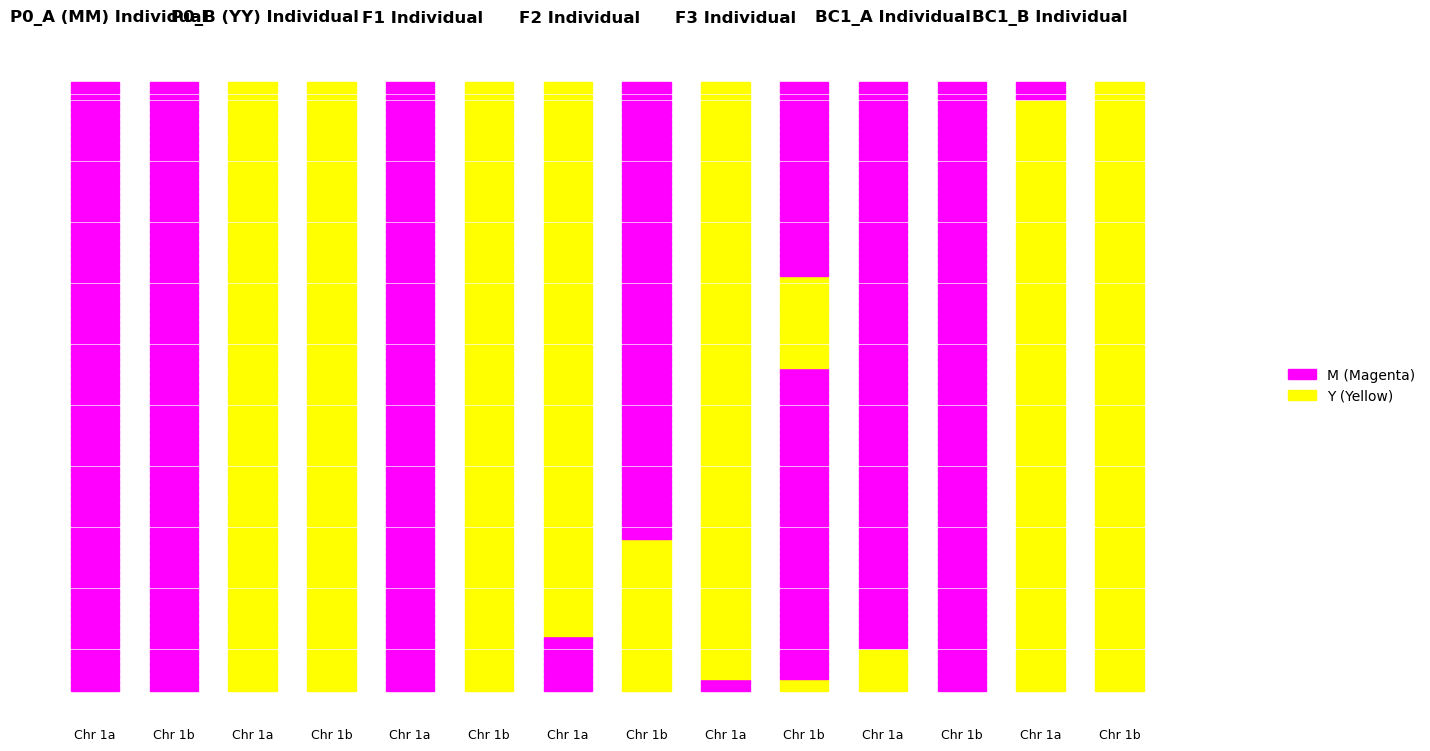

In [12]:
# Visualise Representative Chromosomes Across Generations

print("\n--- Visualising Representative Chromosomes ---")

# 1. Select representative individuals from the generated populations.
# P0_A: The initial Magenta homozygous parent.
representative_p0_a = p0_a_individual
# P0_B: The initial Yellow homozygous parent.
representative_p0_b = p0_b_individual

# F1: The first individual from the F1 generation (all F1s are identical genetically).
representative_f1 = f1_population[0]

# F2: The first individual from the F2 generation.
representative_f2 = f2_population[0]

# F3: The first individual from the F3 generation.
representative_f3 = f3_population[0]

# BC1_A: The first individual from the F1 x P0_A backcross.
representative_bc1_a = bc1_a_population[0]

# BC1_B: The first individual from the F1 x P0_B backcross.
representative_bc1_b = bc1_b_population[0]


# 2. Compile lists of individuals and their corresponding titles for the plotting function.
individuals_to_plot = [
    representative_p0_a,
    representative_p0_b,
    representative_f1,
    representative_f2,
    representative_f3,
    representative_bc1_a,
    representative_bc1_b
]

titles = [
    "P0_A (MM) Individual",
    "P0_B (YY) Individual",
    "F1 Individual",
    "F2 Individual",
    "F3 Individual",
    "BC1_A Individual",
    "BC1_B Individual"
]

# Call the plotting function.
# We'll plot only the first chromosome pair for each individual for clarity across generations.
# 'max_chromosomes_to_plot=1' ensures only one diploid pair is shown per individual,
# which is crucial for individuals with many chromosome pairs (like F2 onwards).
plot_individual_chromosomes(individuals_to_plot, titles, chromosome_length, max_chromosomes_to_plot=1)


--- Plotting Triangle Plot ---


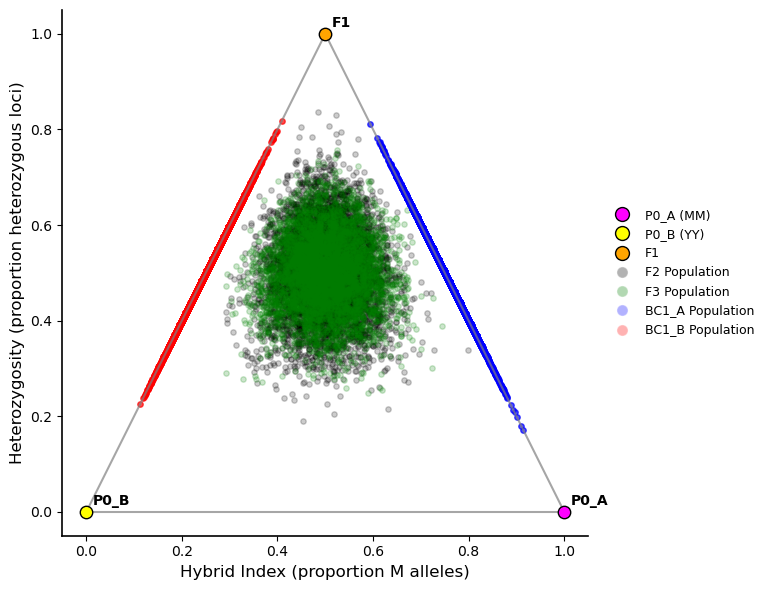

In [13]:
# Triangle Plotting

# This cell is responsible for visualising the genetic data on a triangle plot (Hybrid Index vs. Heterozygosity).
# Each point on this plot represents a single individual, showing their overall hybrid status.
# This plot provides a concise summary of the genetic composition of a hybrid population.

print("\n--- Plotting Triangle Plot ---")

# Create a new figure and a single subplot for the plot.
# 'figsize=(8, 6)' sets the width and height of the plot in inches.
fig, ax = plt.subplots(figsize=(8, 6))

# Customise the plot's appearance by removing the top and right spines (borders)
# for a cleaner look, and setting the line width for the bottom and left spines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Set the labels for the X and Y axes, making them descriptive and readable.
ax.set_xlabel("Hybrid Index (proportion M alleles)", fontsize=12)
ax.set_ylabel("Heterozygosity (proportion heterozygous loci)", fontsize=12)

# Plot the F2 individuals as a scatter plot.
# Each point corresponds to one F2 individual's aggregate Hybrid Index and Heterozygosity.
# 'alpha=0.1' makes the points semi-transparent, which is useful for large populations where points overlap,
# allowing density to be perceived. 's=15' sets the size of each scatter point.
ax.scatter(
    f2_hybrid_indices,    # X-coordinates: Hybrid Index for each F2 individual.
    f2_heterozygosities, # Y-coordinates: Heterozygosity for each F2 individual.
    color='black',        # Colour of the scatter points.
    alpha=0.2,            # Transparency level.
    s=15,                 # Size of the markers.
    label='F2 Population' # Label for this data series, used in the legend.
)

# Plot the F3 individuals as a scatter plot.
# Each point corresponds to one F3 individual's aggregate Hybrid Index and Heterozygosity.
# 'alpha=0.1' makes the points semi-transparent, which is useful for large populations where points overlap,
# allowing density to be perceived. 's=15' sets the size of each scatter point.
ax.scatter(
    f3_hybrid_indices,    # X-coordinates: Hybrid Index for each F2 individual.
    f3_heterozygosities, # Y-coordinates: Heterozygosity for each F2 individual.
    color='green',        # Colour of the scatter points.
    alpha=0.2,            # Transparency level.
    s=15,                 # Size of the markers.
    label='F3 Population' # Label for this data series, used in the legend.
)

# Plot the BC1_A individuals as a scatter plot.
# Each point corresponds to one BC1_A individual's aggregate Hybrid Index and Heterozygosity.
# 'alpha=0.1' makes the points semi-transparent, which is useful for large populations where points overlap,
# allowing density to be perceived. 's=15' sets the size of each scatter point.
ax.scatter(
    bc1_a_hybrid_indices,    # X-coordinates: Hybrid Index for each F2 individual.
    bc1_a_heterozygosities, # Y-coordinates: Heterozygosity for each F2 individual.
    color='blue',        # Colour of the scatter points.
    alpha=0.7,            # Transparency level.
    s=15,                 # Size of the markers.
    label='BC1_A Population' # Label for this data series, used in the legend.
)

# Plot the BC1_B individuals as a scatter plot.
# Each point corresponds to one BC1_B individual's aggregate Hybrid Index and Heterozygosity.
# 'alpha=0.1' makes the points semi-transparent, which is useful for large populations where points overlap,
# allowing density to be perceived. 's=15' sets the size of each scatter point.
ax.scatter(
    bc1_b_hybrid_indices,    # X-coordinates: Hybrid Index for each F2 individual.
    bc1_b_heterozygosities, # Y-coordinates: Heterozygosity for each F2 individual.
    color='red',        # Colour of the scatter points.
    alpha=0.7,            # Transparency level.
    s=15,                 # Size of the markers.
    label='BC1_B Population' # Label for this data series, used in the legend.
)

# Plot the parental (P0) and F1 reference points on the same plot.
# These points are typically fixed and represent the extreme ends or the exact middle of the hybridisation spectrum.
ax.scatter(p0_a_hi, p0_a_het, color='magenta', s=80, edgecolor='black', zorder=5, label='P0_A (MM)') # Magenta parent, zorder for visibility
ax.scatter(p0_b_hi, p0_b_het, color='yellow', s=80, edgecolor='black', zorder=5, label='P0_B (YY)') # Yellow parent
ax.scatter(f1_representative_hi, f1_representative_het, color='orange', s=80, edgecolor='black', zorder=5, label='F1') # F1 generation

# Add annotations (text labels) next to the P0 and F1 points for clear identification on the plot.
# 'xytext' offsets the text from the point, and 'textcoords='offset points'' specifies the offset unit.
ax.annotate('P0_A', (p0_a_hi, p0_a_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax.annotate('P0_B', (p0_b_hi, p0_b_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax.annotate('F1', (f1_representative_hi, f1_representative_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# Draw the edges of the triangular region that typically encompasses hybrid individuals.
# This visually defines the space where different types of hybrids are expected to fall.
triangle_edges = [
    [(0.0, 0.0), (0.5, 1.0)], # Edge from YY (0,0) to F1 (0.5,1)
    [(0.5, 1.0), (1.0, 0.0)], # Edge from F1 (0.5,1) to MM (1,0)
    [(0.0, 0.0), (1.0, 0.0)]  # Edge from YY (0,0) to MM (1,0) (the x-axis, representing pure homozygotes)
]
for (x0, y0), (x1, y1) in triangle_edges:
    ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

# Set the limits for the X and Y axes. Slightly extend them beyond 0-1 to prevent points from being cut off at the edges.
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
# Disable the grid for a cleaner aesthetic, often preferred in these types of plots.
ax.grid(False)
# Ensure the aspect ratio is equal so the triangle appears geometrically correct (not stretched).
ax.set_aspect('equal', adjustable='box')

# Create custom legend elements to clearly label the different populations on the plot.
# Line2D is used to create proxy artists for the legend that mimic the scatter plot markers.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=10, markeredgecolor='black', label='P0_A (MM)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, markeredgecolor='black', label='P0_B (YY)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, markeredgecolor='black', label='F1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', alpha=0.3, markersize=8, label='F2 Population'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.3, markersize=8, label='F3 Population'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', alpha=0.3, markersize=8, label='BC1_A Population'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', alpha=0.3, markersize=8, label='BC1_B Population')
]

# Add the legend to the plot.
# 'loc="center left"' positions it to the left of the centre.
# 'bbox_to_anchor=(1.02, 0.5)' places it just outside the main plot area to the right, centred vertically.
# 'frameon=False' removes the legend's border for a cleaner look.
ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=9)

# Adjust plot layout to prevent labels/legend from overlapping with the plot area.
plt.tight_layout()
# Further adjust the right margin to accommodate the legend.
plt.subplots_adjust(right=0.8)
# Display the plot.
plt.show()

In [14]:
# Create and Display Final Detailed DataFrame

# This cell converts the global list of detailed genetic records into a pandas DataFrame.
# This DataFrame contains locus-level genotype information for every individual across all simulated generations.

print("\n--- Genetic Data DataFrame (First 5 rows) ---")
# Create the DataFrame from the collected records.
genetic_df = pd.DataFrame(genetic_data_records)
# Display the first 5 rows of the DataFrame to inspect its structure and content.
print(genetic_df.head())
# Print the total number of records (rows) in the DataFrame.
print(f"\nTotal records in DataFrame: {len(genetic_df)}")

# You can now filter this DataFrame to analyse specific generations:
# For example, to get F3 data:
# f3_df = genetic_df[genetic_df['generation'] == 'F3']
# print("\nF3 Data Sample:")
# print(f3_df.head())

# To get BC1_A data:
# bc1_a_df = genetic_df[genetic_df['generation'] == 'BC1_A']
# print("\nBC1_A Data Sample:")
# print(bc1_a_df.head())


--- Genetic Data DataFrame (First 5 rows) ---
  generation  individual_id  diploid_chromosome_id  locus_position genotype
0       P0_A              1                      1               0      M|M
1       P0_A              1                      1               1      M|M
2       P0_A              1                      1               2      M|M
3       P0_A              1                      1               3      M|M
4       P0_A              1                      1               4      M|M

Total records in DataFrame: 20010200
